## Reading the data

In this notebook, we show how to read the dataset. 

Our dataset can be found [here](https://data.world/maxstrange/diplomacyboardgame).

During our analysis, we realised that 'units' have a duplication problem. For several games, all units were replicated. Hence, we remove those. By precaution, we also remove duplicate for orders and for turns. 

In [5]:
import pandas as pd
import time
from collections import deque
import numpy as np
pd.options.mode.chained_assignment = None

In [6]:
# read the dataframes
all_games = pd.read_pickle("data/games.pkl")
all_orders = pd.read_pickle("data/orders.pkl")
all_players = pd.read_pickle("data/players.pkl")
all_turns = pd.read_pickle("data/turns.pkl")
all_units = pd.read_pickle("data/units.pkl")

# remove duplicates
all_units = all_units.drop_duplicates()

In [7]:
all_games.head(3)

,id,num_turns,num_players
0,37317,166,7
1,37604,51,7
2,39337,101,7


## Detecting betrayal

What I want to do here is **to detect betrayals within a game**, using the same definitions as in the paper we have studied. Let's recall a few things, and we will explore the dataset based on those definitions.

### What are game actions ? 

Each player has **units** (one per each city a player controls) and thoses are moved using **orders**. There are 2 kinds of orders: 
- **support** order: two units join and become bigger (i.e. stronger). One player can support another.
- movement: move a unit somewhere. If it meets another player's unit, it will be a **battle**

### How to define relationships ? 

Let's follow the definitions given by the paper.

**Act of friendship**: when a player supports another.

**Act of hostility**: When a player invades another, or if a player supports an invasion to the other player's territory.

**Friendship**: a relationship between two players spanning over 3 seasons containing at least 2 **consecutive and reciprocated** acts of friendships.

**Betrayal** / **Broken friendship**: When, after being in a friendship, two players engage in at least 2 acts of hostility. 

### Additional information required for data-processing

It is important to understand the [rules of the game](https://www.playdiplomacy.com/help.php?sub_page=Game_Rules).

Here is a list of points we want to raise before starting the programming, obtained from looking at the rules.
- Each **year** is breaked down into 2 **seasons**: {'Spring', 'Fall'}.
- Each **seasons** is itself divided into several phases, called **turns** (therefore, a year is made of at least 2 turns, and not more than 5):
    - **orders**: each player submit orders to all of its units (that can be **hold**, **move**, **support** or **convoy**)
    - **retreats**: a phase that happens when some units (called **disloged units**) need to retreat. If they can't, they are destroyed
    - **builds**: only happens after the *fall retreat*. Players gain control of SCS they are occupying.
- Geographically, the game is divided into **provinces**
- some provinces are called **supply centers** (SCS) and to win a **player** must control 18 supply centers.
- Each **unit** belongs to a **player** and there can be **only 1 unit** in a province at a time, however **units** can join their force with **support order**.
- There are 2 types of **units**:  {'F' or 'A'} for {Fleet, Army}
- Each **player** is characterized by its country, encoded by a letter: {E,F,I,G,A,T,R} standing for {England, France, Italy, Germany, Austria, Turkey, Russia}

We also give an clarification for the rows of 'all_orders' (i.e. the proper orders) because we will be using those quite a lot, and it can be hard to understand. 
- orders are defined by a **game_id**, a **unit_id** and **turn_number** (which makes sense, considering all the above points). 
- each order has a field **location** which is the province of origin of the unit
- depending on the **unit_order**, here is the description of the fields

| unit_order | location                 | target                            | target_dest     |
| ---------- | ------------------------ | --------------------------------- | --------------- |
| MOVE       | initial loc. of the unit | loc. to move to                   | null            |
| HOLD       | initial loc. of the unit | null                              | null            |
| CONVOY     |                          | initial loc.                      | end goal loc.   |
| SUPPORT    |                          | loc. of unit to be supported      | its target loc. |
| BUILD      | ""                       | encoded string like 'army Berlin' |                 |
| RETREAT    | initial loc. of the unit | target loc                        |                 |
| DESTROY    | initial loc. of the unit |                                   |                 |

### What the map looks like ! 

<img src="img/map.png" width="900">

# Discovering the Dataset

Now that all of this is well-defined, let's see what we can achieve in the code. As it can be quite hard to see how to do this, let's break this down and look at one game.

In [8]:
# extract one game
# 37317
# 120600
game = all_games.query("id == 37317")
game_id = game.iloc[0,0]
game

,id,num_turns,num_players
0,37317,166,7


In [9]:
# for this game, extract turns, orders and units
turns = all_turns.query("game_id == {}".format(game_id))
orders = all_orders.query("game_id == {}".format(game_id))
units = all_units.query("game_id == {}".format(game_id))
orders.head()

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11451415,37317,0,MOVE,Edinburgh,North Sea,None,1,None,1
11451416,37317,1,MOVE,Liverpool,Belgium,None,0,Illegal order replaced with Hold order,1
11451417,37317,2,HOLD,London,None,None,1,None,1
11451418,37317,3,MOVE,Marseilles,Spain,None,1,None,1
11451419,37317,4,MOVE,Paris,Burgundy,None,0,Bounced,1


## Can we find **acts of friendships** ?

It's firstly defined by a support. However it is not enough: a player could support himself (and that's not a friendship). So we must also look at the **last previous orders** asking to **MOVE** the unit towards the support's **target** destination. This will link to a 'unit_id' (the one that followed this order) and therefore giving access to the country who made the call.

In [10]:
# first we must look at the supports that happened in this game.
supports = orders.unit_order == "SUPPORT"
orders_w_supports = orders[supports]
orders_w_supports.sample(3)

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11452088,37317,24,SUPPORT,Aegean Sea,Tunis,Smyrna,1,None,16
11452705,37317,31,SUPPORT,Black Sea,Sevastopol,Armenia,0,Support cut by f con - bla,28
11452618,37317,29,SUPPORT,Warsaw,Ukraine,Ukraine,1,None,26


In [11]:
# we want to find the countries of the supported units
# let's take one and see what we can do
support_order = orders_w_supports.iloc[-4]
# support_order = orders_w_supports.head(3).tail(1)
support_order

game_id                             37317
unit_id                                12
unit_order                        SUPPORT
location                          Galicia
target                             Vienna
target_dest                       Bohemia
success                                 0
reason         Support cut by a war - gal
turn_num                               33
Name: 11452914, dtype: object

In [12]:
# Example: there is a support from 'Vienna' to 'Bohemia' 
# we know that in one of the previous orders, someone made a move with destination 'Vienna'
target = support_order.target#.values[0]
turn_number = support_order.turn_num#.values[0]
move_order = orders.query("unit_order == 'MOVE' & target == '{}' & turn_num < {}".format(target, turn_number)).tail(1)
move_order

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11451517,37317,20,MOVE,Galicia,Vienna,None,0,Bounced,3


In [13]:
unit_id = move_order.unit_id.values[0]
move_unit = units.query("unit_id == {}".format(unit_id))
move_unit

,game_id,country,type,start_turn,end_turn,unit_id
1035275,37317,R,A,0,45,20


We see that rusian was the country who had moved it's army there the last time before a support happened. Hence, 'Russia is the supported Country'.

In [14]:
# Let's look at the country who did the support
unit_id = support_order.unit_id# .values[0]
support_unit = units.query("unit_id == {}".format(unit_id))
support_unit

,game_id,country,type,start_turn,end_turn,unit_id
1035256,37317,A,A,0,110,12


As it turns out this **is** an act of friendship: Russia was supported by Austria, when it moved from Vienna to Bohemia, by Austrian soldiers who were in Galicia. As we can see on the map, this is perfectly coherent with the geographical position of provinces.

## A little data pre-processing won't hurt us

Now is when we realize it would be nice to have an extra information about orders. This can be seen as a pre-processing step, since it will be computed only once. 

First thing that we want to have is to know **what country passed which order**.

As we will see later on, we will also need **the year and the season at which each order was passed**, in order to find friendships with more precisions than if we use only 'year' as indicator of when an order happens. Here is how we can encode this: 
- the spring of a year is writen as the year, for instance 'Spring 1904' = 1904
- the fall of the same year is written as the year + 0.5, for instance 'Fall 1904' = 1904.5

Also, there is sometimes a problem with the data. Order with id == 89268 for instance has the 'units' that are duplicated. Possible way to solve this is to run `units.drop_duplicates()`. It's not the only possible problem with the 'unit' array, indeed sometimes there are duplicates that are 'almost exactly the same, but not exactly. The end turn would be sligtly different. The solution to this problem is simply to expect an error and if one is catched, to skip this game.

In [15]:
try: 
    # 1. compute the country who emitted each order 
    countries = orders.unit_id.apply(lambda x: units.query("unit_id == {}".format(x)).country.item())
    # compute the 'encoded year' at which each order was passed
    turns["season_encoded"] = turns["year"] + 0.5 * (turns["season"] == "Fall")
    years = orders.turn_num.apply(lambda x: turns.query("turn_num == {}".format(x)).season_encoded.item())
    # update the orders
    orders["country"] = countries
    orders["year"] = years
except ValueError:
    print("Data is corrupted and execution was aborted")

Finally, a last step we will need is more **information about the 'target country'**. When an order is passed, there is often another country located where the order's target is. This information is really important to us. Let's find it here.

In [16]:
def get_target_country(order, orders):
    """
    Given an order MOVE or SUPPORT, it returns the country that controls the targeted province.
    The function looks at 'the last successful move towards the targetted province'.
    If none is found, returns None.
    If order is not MOVE or SUPPORT, it returns empty string.
    """
    if order.unit_order not in ["MOVE", "SUPPORT"]: return ""
    # get the last move orders to this province
    q = "(unit_order in ('MOVE' ,'RETREAT', 'HOLD')) & success == 1 & target == '{}' & turn_num < {}".format(order.target, order.turn_num)
    last_move_orders = orders.query(q)
    if len(last_move_orders):
        # extract the order
        last_move_order = last_move_orders.iloc[-1]
        return last_move_order.country
    else:
        # this is when there never was a successful move toward this 
        return "None"

In [17]:
# get target country
targets = orders.apply(lambda o: get_target_country(o, orders), axis = 1)
orders["target_country"] = targets
orders.sample(5)

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num,country,year,target_country
11452374,37317,17,SUPPORT,Sevastopol,Moscow,Ukraine,1,None,21,T,1905.0,None
11451763,37317,10,HOLD,Holland,None,None,1,None,8,G,1902.5,
11451789,37317,15,HOLD,Bulgaria,None,None,1,None,8,T,1902.5,
11452485,37317,31,SUPPORT,Black Sea,Sevastopol,Rumania,0,Supported unit has failed,23,T,1905.5,T
11452673,37317,7,HOLD,Ankara,None,None,1,None,28,I,1906.5,


## Acts of **friendships** and Acts of **hostility**

Now that we have a good dataframe, let's start the processing.

### Finding **acts of friendship**

This function is just a rewriting of all the code which was presented above.

Note that we don't add the query criteria 'success == 1' because it's not the result which defines the intention of the act. You can plan to attack someone and fail, you will still have performed a hostile action toward the other player.

In [18]:
def is_order_act_of_friendship(support_order):
    # only interested in SUPPORT orders to other countries
    if support_order.unit_order != "SUPPORT": return False
    if support_order.target_country == "None": return False
    return support_order.country != support_order.target_country

In [19]:
# so we may add this to the orders dataframe
acts_of_friendships = orders.apply(is_order_act_of_friendship, axis = 1)
acts_of_friendships.value_counts()

False    461
True      21
dtype: int64

Good news : it's working. As we see, there is another column 'acts_friendships' which tell if this order was an act of friendships-

### Finding **acts of hostility**

The code is quite the same, just the logic is a little tweaked. 

We are looking at all **orders** with **unit_order** that is **MOVE** (*this is how an attack starts*), where the **target** is a province with a unit of another player. Again, the tricky part is to see if there is another player's unit located at this province. We must look at all **previous orders** with the same **target** done by a unit from **another country**.

In [20]:
def is_move_act_of_hostility(move_order):
    if move_order.unit_order != "MOVE": return False
    if move_order.target_country == "None": return False
    return move_order.country != move_order.target_country

In [21]:
acts_of_hostility = orders.apply(is_move_act_of_hostility, axis = 1)
acts_of_hostility.value_counts()

False    410
True      72
dtype: int64

## Who is friend with who

Now that we have classified our orders, let's find friends within our game. Coming back to our definition:

> Friendship is a relationship between two players spanning over 3 seasons containing at least 2 consecutives and reciprocated acts of friendships.

The difficulty comes from the identification of the country who received the support. Let's add another function to solve this problem which we will be able to call for both the acts of friendships and the acts of hostility. In both case, it's the **target province** that matters.

In [22]:
friendly_orders = orders[acts_of_friendships]
hostile_orders = orders[acts_of_hostility]

For each order in the above set , assuming the 'supporting country' is X and the 'supported country' is Y, we must look if there exist in the last 2 years: 
- at least 1 previous order with 'X supports Y'
- at least 2 previous orders with 'Y supports X'

Those acts of frienships are part of a **friendships**.

Let's create a table which will recap all friendships and potential betrayal, and then let's fill it up with the data already extracted. 

In [23]:
def get_countries_code(x,y):
    """Given two countries, it returns another string being their letters sorted alphabetically.
    This string is the 'encoded friendship name'."""
    return ''.join(sorted(x + y))

In [24]:
def analyse_friendships(df):
    """Given the friendship dataframe, it will extract insights out of it"""
    # get columns where something happened
    cols = [col for col in df.columns if np.count_nonzero(friendships[col] != 0)]
    if len(cols):
        print("- friendships:", cols)
        for c in cols: 
            tmp = df.loc[:,c]
            pos = tmp[tmp != 0].values
            # print(pos)
            if type(pos[-1]) is str: 
                print("    * length of friendship ",c," is ", len(pos) - 1)
                print("        ->",c," ends betrayed by ",pos[-1],"") 
            else: 
                print("    * length of friendship: ", len(pos))

    else:
        print("- No friendships was found")

Our first attempt to find friendships and betrayals led us to write those 2 functions. They work 95% of the times, but not always. The often identify friendships that are too short, for instance.

In [25]:
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs = [x+y for x in countries for y in countries if y > x]
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
# create a dataframe each possible friendships and each years
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)

In [26]:
def find_friendships(friendships, friendly_orders, hostile_orders, length_year = 1.5):
    """Will fill the 'friendships' dataframe by adding '1's to signify that a pair of players engaged in a 
    reciprocal friendships
    
    Careful, the function doesn't return anything - instead it changes the 'friendship' dataframe
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    friendly_orders (pd.DataFrame): frame of all order with an 'act of friendship'
    length_year (int): minimum amount of time that must pass between the first AOF and the last one.
    
    Discussion
    For each order with an AOF, it will query all other ones that 
    - happened before
    - involved exactly the same 2 countries
    Then it makes sure that amongs all those orders
    - each player originated at least 2 of them
    - that the time spent between the first one and the last one was longer than `length_year` 
    Those orders are the ones defining a friendships.
    """
    # for each friendly order, finds those that define a friendship
    for i, o in friendly_orders.iterrows():
        x, y, year = o.country, o.target_country,  o.year
        # this line doesn't remove frienships because we are only looking are reciprocal ones
        if y > x: continue
        # make a query over others friendly orders from the past (including this one !)
        q = "year <= @year & ( (country == @x & target_country == @y) | (country == @y & target_country == @x) )"
        query = friendly_orders.query(q)
        # extract number of helps from 2 countries
        n_x = np.count_nonzero(query.country == x)
        n_y = len(query) - n_x
        y_min = query.year.min()
        y_max = query.year.max()
        # print("output of query: ",get_countries_code(x,y), y_min, y_max)
        if n_x >= 2 and n_y >= 2 and (y_max - y_min) >= length_year:
            # they meet all criteria about 'being nice to each other'
            code = get_countries_code(x,y)
            friendships.loc[query.year.min():o.year, code] = 1
            # we just want to make sure they are not 'being not nice' as well ! 
            # each time we find an AOH, we must break the friendship at this year
            q = "year < @y_max & year > @y_min & country in (@x, @y) & target_country in (@x, @y)"
            query = hostile_orders.query(q)
            for i, hostile_order in query.iterrows(): 
                # print("   hostile act detected ", code, hostile_order.year, hostile_order.unit_id)
                friendships.loc[hostile_order.year, code] = 0            
    

In [27]:
def find_betrayals(friendships, hostile_orders, N_hostile_min = 2):
    """Will fill the 'friendships' dataframe by removing '1' when a friendship was broken and if a 
    betrayal is detect, it will add its country letter to the frame. 
    
    Careful, the function doesn't return anything - instead it changes the 'friendship dataframe
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    hostile_orders (pd.DataFrame): frame of all order with an 'act of hostility'
    N_hostile_min (int): minimum number of hostile action to consider this event as a betrayal
    
    Discussion
    For each order, if the players were engaged in a friendship, it will first destroy the friendship and 
    then verifiy that the event is considered as a betrayal according to our definition.
    """
    for i, o in hostile_orders.iterrows():
        x = o.country
        y = o.target_country
        code = get_countries_code(x,y)
        if friendships.loc[o.year, code]:
            # 1. it breaks the friendship
            friendships.loc[o.year+0.5:, code] = 0 
            # 2. did a betrayal happened ? 
            # we must just verify that another hostile action happened after this
            q = "year >= {}  & ((country == @x & target_country == @y) | (country == @y & target_country == @x) )".format(o.year, x, y)
            query = hostile_orders.query(q)
            if len(query) >= N_hostile_min: 
                # print("   - betrayal happened for ", code)
                friendships.loc[o.year, code] = x 

In [28]:
# let's test those functions
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)
find_friendships(friendships, friendly_orders, hostile_orders)
find_betrayals(friendships, hostile_orders)
print(friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]])
analyse_friendships(friendships)

         AI
1901.0  0.0
1901.5  0.0
1902.0  0.0
1902.5  0.0
1903.0  0.0
1903.5  0.0
1904.0  0.0
1904.5  1.0
1905.0  0.0
1905.5  1.0
1906.0  1.0
1906.5  1.0
1907.0  1.0
1907.5  1.0
- friendships: ['AI']
    * length of friendship:  6


As we can see here, there is something wrong with this code. In this friendship (for game 37317) there is a problem in the year 1904 for the friendship 'AI'. It is hard to fix this problem with the current approach and we had to leave it behind. However, even if those function are not definitive, they helped us a lot to identify a better code and that is why we have let them here. Let's now go through to code that works ! 

### Finding Friendships Algorithm

The final algorithm to find friendships and betrayals is a rather complex, so here is a high-level explanation of what it does.

*Abreviations used recurrently in the code*
- AoF = "Act of friendship"
- AoH = "Act of hostility"

The main idea of the algorithm is to consider series of AoFs that we calls '**bags of AoF**'. Those bags, with what separates them, is what to be analysed. Let's define 2 criteria, internal and external. 

a. **Internal criteria** that a bag of AOFs must verify (*internal* because it only depends on the AoFs only)
- more than 2 acts emitted by the 2 countries
- the overall time elapsed is longer than 1.5 years

b. **External criteria** that a bag of AoFs must verify (*external* because the criteria depend on the AoHs that happened at the same time)
- no AoH in the same time range


It goes like this:

**For each pair of countries** (*their friendship is represented by a column of the 'friendships' dataframe*): 
1. Find all AOFs that happened between them. Consider them as a bag of AoFs. 
2. Verify that this 'bag of acts of friendships' (BAOF) verifies the *internal criteria* mentioned above. If so, fill between the first season and the last season with '1's. Else, make sure '0' are placed at the season of interest. 
3. Find acts of hostility that happened between the same time range as the bag of words. Split the bag of words (*actually, it's the seasons array that is split*) for every act of hostility so that we obtain 
4. For each bag of AoF (hence, un-interupted by hostility, so external validity is verified !) verify again internal validity. If not verified, replace '1's with zeros.
5. Find betrayal, as the event:  "breaking a bags of AoFs with more than 1 hostile action"


Let's note that since the step 3 doesn't need to be repeated, it is not a recursive aglorithm. 

In order to implement this algorithm, we need a 'splitting' function which also is a little tricky. There are several ways to do this splitting properly (recursive spliting would be one way) but we will use a vectorized approach to do so. We want to split a list of 'ones' divided by zeros into a list of 'bags' of ones. Let's just show how one can do that here

In [29]:
# illustration of the splitting algorithm 
ones = np.array([1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
delta = ones[1:] - ones[:-1]
idcs = np.where(delta != 0)[0]+1
bags = np.split(ones, idcs)
bags

[array([1.]),
 array([0., 0.]),
 array([1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1.])]

As we can see, it works well ! Let's just write a few functions for those tasks, and then we can implement the overall algorithm safely.

In [30]:
length_year = 1.5
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs_tuple = [(x,y) for x in countries for y in countries if y > x]

def are_AOFs_friendship(AOFs, x, y, length_year = 1.0, n_xy_min = 2, n_min = 4):
    """Internal validity criteria:
    Given a dataframe of 'AoF's, and the 2 countries of interest, 
    it returns the validity of this series of friendly actions. 
    """
    if not len(AOFs): return False, None, None
    # extract number of helps from both countries
    n_x = np.count_nonzero(AOFs.country == x)
    n_y = len(AOFs) - n_x
    # extract information about the year
    y_min = AOFs.year.min()
    y_max = AOFs.year.max()
    # print(get_countries_code(x,y), y_min, y_max)
    return (n_x >= n_xy_min and n_y >= n_xy_min and (n_x + n_y) >= n_min and (y_max - y_min) >= length_year), y_min, y_max

def get_bags_of_ones_idcs(ones):
    """Given an numpy array of ones, returns the indices where to split the array 
    so that all ones are together and all zeros together, in sub arrays, once split."""
    delta = ones[1:] - ones[:-1]
    idcs = np.where(delta != 0)[0]+1
    return idcs

Here is the infamous function.

In [31]:
def find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min = 2, ):
    """Fills the 'friendships' dataframe by adding '1's to signify that a pair of players engaged in a 
    reciprocal friendship.
    
    Careful, the function doesn't return anything - instead it changes the 'friendships' dataframe
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    friendly_orders (pd.DataFrame): frame of all orders with an 'act of friendship'
    length_year (int): minimum amount of time that must pass between the first AOF and the last one.
    N_hostile_min (int): min number of AoH so that a broken friendship is considered as a betrayal. 
    """
    for pair in pairs:
        # 1. make a query for all acts of support of this pair of countries    
        x, y = pair
        q = "country in (@x, @y) & target_country in (@x, @y)"
        query1 = friendly_orders.query(q)
        # 2. verify internal validity of AoFs
        is_valid, y_min, y_max = are_AOFs_friendship(AOFs = query1, x = x, y = y)
        if is_valid:
            # Fill with '1' everywhere
            code = get_countries_code(x,y)
            friendships.loc[y_min:y_max, code] = 1
            # Look for hostilities
            q = "year < @y_max & year > @y_min & country in (@x, @y) & target_country in (@x, @y)"
            query2 = hostile_orders.query(q)
            # Each time we find an AOH, break the friendship at this season
            for i, hostile_order in query2.iterrows(): 
                friendships.loc[hostile_order.year, code] = 0    
            # Verify again that each small bag of AoFs is valid or not
            # a. get the indices using the values 
            idcs = get_bags_of_ones_idcs(friendships.loc[y_min:y_max, code].values)
            # b. and make the split using the indices of the dataframe
            bags_of_years = np.split(friendships.loc[y_min:y_max, code].index.values, idcs)
            # c. loop inside even (not odd) bags of years (the other ones are those with betrayals)
            # we know the first one '0' will be containing a friendship, that's why we can do this
            for years in bags_of_years[::2]: 
                AoFs = query1.query("year in @years")
                # print(AoFs[["year","unit_order", "country", "target_country"]], "\n")
                is_valid, _, _ = are_AOFs_friendship(AOFs= AoFs, x = x, y = y, n_xy_min = 1, n_min = 3)
                if not is_valid:
                    # this friendship is cancelled
                    friendships.loc[years, code] = 0  
            # Final step: find betrayals inside odd bags of years
            for years in bags_of_years[1::2]:
                # first, verify it's coming after a friendship
                if friendships.loc[years[0]-0.5, code]:   
                    # get the hostile orders in the desired time interval 
                    AoHs = query2.query("year in @years")
                    if len(AoHs) >= N_hostile_min:
                        # betrayal happened here ! 
                        betrayal = AoHs.iloc[0]
                        friendships.loc[betrayal.year, code] = betrayal.country

In [32]:
# let's test this function
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)
find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min=1)
print(friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]])
analyse_friendships(friendships)

         AI
1901.0  0.0
1901.5  0.0
1902.0  0.0
1902.5  0.0
1903.0  0.0
1903.5  0.0
1904.0  0.0
1904.5  0.0
1905.0  0.0
1905.5  1.0
1906.0  1.0
1906.5  1.0
1907.0  1.0
1907.5  1.0
- friendships: ['AI']
    * length of friendship:  5


Good news is: the detection of friendship is now working and all goes inside one function. 

**Note for debugging**: *it is possible to nicely vizualize in a terminal the 'frienships' dataframe and the orders with the following commands**
- to see acts of friendships: `friendly_orders[["year", "country", "target_country"]]`
- same by filtering for 2 countries: `friendly_orders[["year", "country", "target_country"]].query("country in ('E', 'G')")`
- or even the more complete `friendly_orders[["year", "country", "target_country"]].query("country in ('E', 'G') and target_country in ('E', 'G')")` 
- to see friendships that matters: `friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]]`

# Scaling to several games

Until now, we have been only looking at a single game. We must start to scale the analysis to a broader range. Let's see what we can do. The first thing to do is to make the process a little more functional by defining methods for each step of the process.

In [33]:
def get_dataframes(game_id):
    orders = all_orders.query("game_id == {}".format(game_id))
    turns = all_turns.query("game_id == {}".format(game_id))
    units = all_units.query("game_id == {}".format(game_id))
    return orders, turns, units

In [34]:
def get_empty_friendships(max_year):
    countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
    pairs = [x+y for x in countries for y in countries if y > x]
    years = np.arange(1901, max_year + 0.5, 0.5)
    # create a dataframe each possible friendships and each years
    return pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)

In [35]:
def process_orders(orders, turns, units):
    try:
        # 1. compute the country who emitted each order 
        countries = orders.unit_id.apply(lambda x: units[["unit_id", "country"]].query("unit_id == {}".format(x)).country.item())
        orders["country"] = countries
        # 2. compute the 'encoded year' at which each order was passed
        turns["season_encoded"] = turns["year"] + 0.5 * (turns["season"] == "Fall")
        years = orders.turn_num.apply(lambda x: turns.query("turn_num == {}".format(x)).season_encoded.item())
        orders["year"] = years
        # 3. get target countries
        targets = orders.apply(lambda o: get_target_country(o, orders), axis = 1)
        orders["target_country"] = targets
        return True
    except ValueError:
        print("Data is corrupted and execution was aborted")
        return False

In [36]:
def analyse_game(game, verbose = False):
    # get dataframes and process them
    orders, turns, units = get_dataframes(game_id = game.id.item())
    has_succeeded = process_orders(orders, turns, units)
    if not has_succeeded: return None, None, None
    
    # find acts of friendships / hostility
    acts_of_friendships = orders.apply(is_order_act_of_friendship, axis = 1)
    acts_of_hostility = orders.apply(is_move_act_of_hostility, axis = 1)
    friendly_orders = orders[acts_of_friendships]
    hostile_orders = orders[acts_of_hostility]
    if verbose:
        print("- {} acts of friendship and {} acts of hostility over {} orders ".format(len(friendly_orders), len(hostile_orders), len(orders)))
    
    # construct friendship matrix
    if len(friendly_orders) and len(hostile_orders):
        friendships = get_empty_friendships(max_year = max(friendly_orders.year.max(), hostile_orders.year.max()))
        find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min=1)
        return friendships, friendly_orders, hostile_orders
    else: 
        return None, None, None

Now that we have all our functions, we can verify that we obtain the same results as before (and the answer is "yes we do")

In [37]:
game = all_games.query("id == 37317")
friendships, _, _ = analyse_game(game)
if friendships is not None:
    analyse_friendships(friendships)
else:
    print("No acts of friendships or no acts of hostility")

- friendships: ['AI']
    * length of friendship:  5


We may now try to use those results over more games ! By doing so, one observes that according to our definition, **not all games contain friendships** and **most of the friendships ends - at some point - in a betrayal. This make sense with the 'mindset of the game'. Here is a quote of the creator of the game. No wonders we observe a lot of betrayals.

> "Luck plays no part in Diplomacy. Cunning and cleverness honesty and perfectly-timed betrayal are the tools needed to outwit your fellow players. The most skillful negotiator will climb to victory over the backs of both enemies and friends. Who do you trust?"

In [38]:
# let's run this function N times
N = 1
games_sample = all_games.query("num_turns >= 60").sample(N)
for i, game in games_sample.iterrows(): 
    print("\n*** Game {} ***".format(game.id.item()))
    friendships, _, _ = analyse_game(game)
    if friendships is not None:
        analyse_friendships(friendships)


*** Game 65002 ***
- No friendships was found


We also notice that for many games, there are very few acts of friendships. For instance the game '91 843' has 1002 orders that were passed and only '2' of them were considered as acts of friendships. We guess that there are two types of games: those with many alliances and betrayals, and those with more personal games and players not coordinating a lot. We are only interested into the second types, so we will filter a little bit those games the following way. The next section of this notebook will go through generating datasets that are going to be used after for other statistical analysis.

# Dataset Generation 

As the dataset is really heavy, we decided to generate smaller datasets only containing the data that we care about.

## 1. Overview of what friendship looks like

The next block of code generates a portion of the dataset as numpy objects so that we can later analyse it better. It randomly samples games which have more than 50 turns, because longer games tend to have more friendships (that's about half of all games. as one can see with the .describe function) and if the game has a friendship, it's going to save (i) its game_id and (ii) the generated friendship array as a numpy array (.npy file)

In [39]:
# we see that the median number of turns per game is 46
all_games.num_turns.describe()

count    21197.000000
mean        47.029391
std         16.776897
min          2.000000
25%         36.000000
50%         46.000000
75%         56.000000
max        467.000000
Name: num_turns, dtype: float64

In [40]:
N = 5
n_games = N
verbose = False

game_ids = []
all_friendships = []
games_feature = []

games = all_games.query("num_turns >= 50")

s = time.time()
while n_games:
    game = games.query("id not in @game_ids").sample(1)
    game_id = game.id.item()
    friendships, friendly, hostile = analyse_game(game, verbose = verbose)
    if friendships is not None:
        cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
        if True: #len(cols):
            print("games to find: ", n_games)
            n_games -= 1
            game_ids.append(game_id)
            all_friendships.append(friendships.values)
            games_feature.append((len(friendly), len(hostile), game.num_turns.item()))
            
            if verbose:
                print("Valid GAME was found: ", game_id)
                analyse_friendships(friendships)
                print("")
e = time.time()

print("elapsed: ", e-s)

## TO SAVE:  UNCOMMENT THIS
# np.save("data/subset_T{}_N1_unfiltered/games_id.npy".format(N), np.array(game_ids))
# np.save("data/subset_T{}_N1_unfiltered/games_features_id.npy".format(N), np.array(games_feature, dtype=object))
# np.save("data/subset_T{}_N1_unfiltered/friendships.npy".format(N), np.array(all_friendships, dtype=object))

games to find:  5
games to find:  4
games to find:  3
games to find:  2
games to find:  1
elapsed:  17.017715454101562


## 2. Features generation for machine learning analysis

Let's generate some features that we can later analyse using machine learning methods. 

We want to have 250 betrayals and 250 lastingfriendships. However, it is not the friendships that we care about, but it is rather the seasons of each friendship. Indeed, we want to detect if a player will betray his/her ally during the next season , hence the 'input' of the classifier will be each season of each of those games. 

The first thing to do is write a function `get_features` which, given a friendship and its context (*hence the actions of the involved players*), returns an array of values used to train a machine learning classifier.

In [41]:
def get_xy(code, seasons): 
    """Given a friendship code and an array of seasons, it will return the betrayer and the victim.
    If no betrayal happens, it picked randomly who is what. 
    """
    # find x and y
    xy = list(code)
    if type(seasons[-1]) == str: 
        x = seasons[-1]
    else:
        x = xy[np.random.randint(2)]
    xy.remove(x)
    y = xy[0]
    return x,y


columns = ["game_id", "has_betrayal", "length", "outcome" ,"n_aoh_x", "n_aoh_y", "n_aos_x", "n_aos_y", "supports_xy" , "supports_yx"]


def get_features(game_id, has_betrayal, friendship, friendly_orders, hostile_orders):
    """
    Given the friendships' column representing 1 friendship and several other parameters about the context,
    it will create all the feature vectors for each season, and will return them all together 
    as a Pandas dataframe. 
    
    Parameters
    game_id (int)
    has_betrayal (bool)
    friendship (pd.Serie): column representing the friendship in the friendships frame
    friendly_orders: all friendly orders for this game
    hostile_orders: all hostile orders for this game
    
    Notations
    X = 'betrayer'
    Y = 'betrayed' = 'victim'
    """
    # n = len(friendship[friendship != 0])
    n = len(friendship[friendship == 1])
    features = pd.DataFrame(data=np.zeros(shape=(n, len(columns))),columns = columns)
        
    
    # find betrayals inside this friendship
    betrayals = [type(s) == str for s in friendship]
    code = friendship.name
    # some very rare games have more than 1 betrayal: 90346
    # hence we split the friendshiè into its sub-component
    splitted = np.split(friendship.values, np.where(betrayals)[0]+1)    

    # i: iterator over rows inside the features dataframe
    # j: iterator inside the splitted array we are using
    # s: iterator over each splitted array we are using
    i,j,s = 0,0,0
    for year, season in friendship.iteritems():
        if not season: continue
            
        if type(season) == str: 
            # the betrayals happens --> let's pass to the next splitted
            features.loc[i-1,"outcome"] = 1
            s += 1
            j = 0
        else:
            # it means this is a season where: 
            # - the 2 playes are engaged in a friendship
            # - there is no betrayal (yet...)
            x,y = get_xy(code, splitted[s])
            # 1. Easy features
            features.loc[i,"game_id"] = game_id
            features.loc[i,"has_betrayal"] = has_betrayal
            features.loc[i,"length"] = j+1
            features.loc[i,"outcome"] = 0
            # 2. number of acts of hostility
            # a. n_aoh_x
            h_query = hostile_orders.query("country == @x & year == @year")
            features.loc[i,"n_aoh_x"] = len(h_query)
            # b. n_aoh_y
            h_query = hostile_orders.query("country == @y & year == @year")
            features.loc[i,"n_aoh_y"] = len(h_query)
            # 3. number of AoS emitted towars other players 
            # a. n_aos_x
            f_query = friendly_orders.query("country == @x & target_country != @y & year == @year")
            features.loc[i,"n_aos_x"] = len(f_query)
            # a. n_aos_y
            f_query = friendly_orders.query("country == @y & target_country != @x & year == @year")
            features.loc[i,"n_aos_y"] = len(f_query)
            # 4. Average number of mutual supports for last 3 seasons
            # y to x
            supports_yx = friendly_orders.query("country == @y & target_country == @x & year <= @year & year > (@year-1.5)"
                                               ).groupby("year").apply(len)
            if len(supports_yx): features.loc[i,"supports_yx"] = supports_yx.mean()
            # x to y 
            supports_xy = friendly_orders.query("country == @x & target_country == @y & year <= @year & year > (@year-1.5)"
                                               ).groupby("year").apply(len)
            if len(supports_xy):features.loc[i,"supports_xy"] = supports_xy.mean()
            # last. increment steppers
            i += 1 
            j += 1
            
    return features    

This block of code is only used for debugging. It just creates the variables required to test the `get_features` the following way.

In [42]:
# try this fonction with one game in particular 
# IDs with several things: 90346, 86785, 103566, 100325
game = all_games.query("id == 86785")
game_id = game.id.item()
friendships, friendly_orders, hostile_orders = analyse_game(game, verbose = True)
cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
c = cols[0]
friendship = friendships[c]
get_features(game_id,True , friendship, friendly_orders, hostile_orders)

- 41 acts of friendship and 239 acts of hostility over 1077 orders 


,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,86785.0,True,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
1,86785.0,True,2.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0
2,86785.0,True,3.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0
3,86785.0,True,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
4,86785.0,True,5.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0


Now that we no how to extract features, let's do that many times over 2N games.

In [43]:
### Code to generate machine learning dataset
N = 2
verbose = False

visited_ids = []
n_betrayal, n_no_betrayal = N,N
features = pd.DataFrame(data=np.zeros(shape=(0, len(columns))),columns = columns)

s = time.time()
games = all_games.query("num_turns >= 50")
while n_betrayal or n_no_betrayal:
    # get one game
    game = games.query("id not in @visited_ids").sample(1)
    game_id = game.id.item()
    visited_ids.append(game_id)
    
    # perform our analysis of the game, and test for skip condition
    friendships, friendly_orders, hostile_orders = analyse_game(game, verbose = verbose)
    if friendships is None: continue
        
    # extract columns that matters, and test for skip condition
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    if not len(cols): continue
    
    # for each friendship:
    for c in cols:
        friendship = friendships[c]
        # 1. check if there is a betrayal
        if type(friendship[friendship != 0].iloc[-1]) == str:
            # there is a betrayal
            if n_betrayal: 
                # 2. get the features
                game_features = get_features(game_id, True, friendship, friendly_orders, hostile_orders)
                features = pd.concat([features, game_features])
                n_betrayal -= 1
                # todo: find features
        else:
            # there is no betrayal
            if n_no_betrayal:
                # 2. get the features
                game_features = get_features(game_id, False, friendship, friendly_orders, hostile_orders)
                features = pd.concat([features, game_features])
                # there wasn't a betrayal
                n_no_betrayal -= 1
            
        
            
            
    print("games still to find:  {} with betrayal and {} without betrayals".format(n_betrayal, n_no_betrayal))
    if verbose:
        print("Valid GAME was found: ", game_id)
        analyse_friendships(friendships)
        print("")
e = time.time()

print("elapsed: ", e-s)
## UNCOMMENT to save
# features.to_pickle("data/features_B10_V10_N1/features.pkl")
features.head()

games still to find:  5 with betrayal and 4 without betrayals
games still to find:  5 with betrayal and 3 without betrayals
games still to find:  4 with betrayal and 2 without betrayals
games still to find:  4 with betrayal and 1 without betrayals
games still to find:  4 with betrayal and 0 without betrayals
games still to find:  4 with betrayal and 0 without betrayals
games still to find:  3 with betrayal and 0 without betrayals
games still to find:  3 with betrayal and 0 without betrayals
games still to find:  2 with betrayal and 0 without betrayals
games still to find:  2 with betrayal and 0 without betrayals
games still to find:  1 with betrayal and 0 without betrayals
games still to find:  0 with betrayal and 0 without betrayals
elapsed:  80.13314867019653


,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,83288.0,False,1.0,0.0,2.0,1.0,0.0,1.0,1.000000,1.000000
1,83288.0,False,2.0,0.0,0.0,2.0,0.0,0.0,1.000000,1.000000
2,83288.0,False,3.0,0.0,1.0,1.0,0.0,1.0,1.000000,1.000000
3,83288.0,False,4.0,0.0,1.0,0.0,2.0,0.0,1.000000,0.000000
4,83288.0,False,5.0,0.0,1.0,2.0,1.0,0.0,1.000000,0.000000
0,110399.0,False,1.0,0.0,0.0,2.0,0.0,0.0,0.000000,0.000000
1,110399.0,False,2.0,0.0,2.0,2.0,0.0,0.0,0.000000,1.000000
2,110399.0,False,3.0,0.0,3.0,2.0,0.0,0.0,1.000000,0.000000
3,110399.0,False,4.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000
4,110399.0,False,5.0,0.0,2.0,2.0,0.0,0.0,1.000000,1.000000


# Machine Learning Analysis: can we predict betrayals using game features ? 

We want to perform a logistic regression with our collected features.

In [44]:
import statsmodels.formula.api as smf
from sklearn.metrics import (confusion_matrix, accuracy_score, plot_confusion_matrix) 

features = pd.read_pickle("data/features_B200_V0_N1/features.pkl")
features.head(2)

,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,54754.0,True,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0
1,54754.0,True,2.0,0.0,1.0,4.0,0.0,0.0,1.0,1.0


In [45]:
# 1. Normalisation 
predictors = ["length", "n_aoh_x", "n_aoh_y","n_aos_x", "n_aos_y", "supports_xy", "supports_yx"]
features = features[predictors + ["outcome"]]

def get_means_and_stds(features, predictors):
    means = []
    stds = []
    for p in predictors: 
        means.append(features[p].mean())
        stds.append(features[p].std())
    return means, stds

def normalise_preds(features, predictors, means, stds):
    for i, p in enumerate(predictors): 
        features[p] = (features[p] - means[i]) / stds[i]
        
        
means, stds = get_means_and_stds(features, predictors)
normalise_preds(features, predictors, means, stds)

In [46]:
# 2. Create the regression formula
formula = "outcome ~ " + ' + '.join(predictors)
formula

'outcome ~ length + n_aoh_x + n_aoh_y + n_aos_x + n_aos_y + supports_xy + supports_yx'

In [47]:
# 3. Make the regression
mod = smf.logit(formula = formula, data = features)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.370756
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 1580
Model:                          Logit   Df Residuals:                     1572
Method:                           MLE   Df Model:                            7
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                 0.07336
Time:                        16:26:49   Log-Likelihood:                -585.79
converged:                       True   LL-Null:                       -632.17
Covariance Type:            nonrobust   LLR p-value:                 3.359e-17
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.0005      0.083    -24.208      0.000      -2.162      -1.839
length          0.5082    

## Classification Assessment

Now that we have fitted a regression model, it is quite hard to interpret the summary. However, we can use additional metrics to see if our model is doing anything like we want to it.

It was for this purpose that we generated another set of points: the testing dataset.

Let's also focus our attention on the seasons where a real betrayal happened, and let's see if this classifier worked properly. It is for this reason that we test the results on the seasons of the testing set with betrayal.

In [48]:
# 1. read the test dataset
features_test = pd.read_pickle("data/features_B20_V0_N1/features.pkl")
normalise_preds(features_test, predictors, means, stds)

X_test = features_test.query("outcome == 1")[predictors]
y_test = features_test.query("outcome == 1")["outcome"]

# 2. predict values and get the binary output
predictions = res.predict(X_test)
binaries = predictions.values.round()
binaries

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.])

The first metric we can look at is the [accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

In [49]:
# 2. accuracy score
accuracy_score(y_test, binaries)

0.045454545454545456

We see that we obtain about 45% of accuracy. Is this good ? Well, it is possible to compare this result with a **dummy estimator** to see if our models performs better than stupid ones. Here, there are several possibilities.
- The 'dumbest' estimator will perform better than this one. Indeed, guessing uniformly between either zero or one will give a 50% chance level to detect betrayals, when only trying to detect betrayals. So when looking dumbly at this task, it looks like what we have isn't good. However, such a result isn't so useful: indeed, there is a strong imbalance in the class labels and if a classifier says that only 50% of seasons are betrayal, it's a really bad. The reason it performs better here is because we selected only seasons where a betrayal happened.
- Another 'dummy' estimator is a stratified one: it generates random predictions by respecting the training set class distribution. We using this one, we obtain a classification score of 10%, which is now a lot less than what was obtained with our predictor.

In [50]:
# 3. dummy estimator for sanity check
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='stratified', random_state=0)
X_train = features[predictors]
y_train = features["outcome"]

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.22727272727272727

We can try to understand more using the confusion matrix. Here, betrayals are marked as negatives. The rows represent the actual classes (first row means no betrayal, second row means betrayal) and the columns represent the predicted class (first row means predicted as no betrayals, second row means predicted as betrayal).

In [51]:
m = confusion_matrix(y_test, binaries)
m

array([[ 0,  0],
       [21,  1]])

With our predictor, about 45% of betrayals are detected as so. One could think that this information is not enough for proclaming "good classifier", because what matters isn't only the 'True Betrayer' but also what happens to the seasons leading to a betrayer (i.e., what about 'False Betrayal' and 'True No Betrayal'. To investigate this result, one can run our previous analysis again without looking only at seasons where betrayal happened.

In [52]:
X_test = features_test[predictors]
y_test = features_test["outcome"]

# 2. predict values and get the binary output
predictions = res.predict(X_test)
binaries = (predictions.values >= 0.5).astype(float)
accuracy_score(y_test, binaries)

0.8465909090909091

In [53]:
clf = DummyClassifier(strategy='stratified')
X_train = features[predictors]
y_train = features["outcome"]

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7443181818181818

In [54]:
m = confusion_matrix(y_test, binaries)
m

array([[148,   6],
       [ 21,   1]])

What do we observe ? The predictor has an overall accuracy of 85%: **this is better than random guess, however it is less than a most-frequent choice** (which guess based on the class distribution, and hence is garuanted to have a much higher accuracy since there is a strong class imbalance). Again, because of the **strong class imbalance**, the accuracy isn't enough to determine, but we can look at the confusion matrix. Again, for this matrix, 'Betrayer' is marked as 'Negatif'.
- The second column of $C$ is same as before, revealing that accuracy of detecting betrayer is really low. Only one betrayal is detected. 
- The first column shows that $148 / 154 \approx 0.96 \%$ of non betrayals seasons are classifed as so. We notice that 6 seasons that are non betrayals are detected as betrayals.

Like in what the paper did, we can ask ourself this question: **is it the case because some betrayals are detected too early ?**. Actually, looking at the data we realize that it is not the case.

After looking at the prediction results, we notice that the for a few games, many betrayals are detected: **how can we enforce that there's only one betrayal per game ?**

Other things that we can do include
- try to design new features
- select features using cross-validation


# Data story plots

This section provides the code to generate several plots used by the datastory. 

## Descriptive statistics

We look at the **outcome** (binary) considering the **treatment**, which can be:
- engaged: player who was engaged in a friendship
- single: player who was not engaged in a friendship

And for engaged player, there is an aditional treatment: 
- betrayer: player who betrayed another one
- betrayed: player who ended up betrayed by another
- neutral: player who was not engaged in a *broken* friendship

In order to answer this question, let's define a few functions that we will use in the later analysis.

In [55]:
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs = [x+y for x in countries for y in countries if y > x]

In [56]:
def get_engageds(friendships):
    """Returns the players engaged in a friendship"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    return list(set(''.join(cols)))

def get_singles(engageds):
    """Returns players not engaged in a friendship"""
    singles = countries.copy()
    for engaged in engageds:
        singles.remove(engaged)
    return singles

In [57]:
def get_betrayers_and_betrayed(friendships):
    """Given the Friendships dataframe as defined in our analysis, returns all the players who commited 
    betrayals and all players who ended up betrayed"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    betrayers = []
    betrayeds = []
    for c in cols: 
        tmp = friendships[c]
        values = tmp[tmp != 0].values
        if type(values[-1]) == str: 
            betrayer = values[-1]
            betrayers.append(betrayer)
            tmp = list(c)
            tmp.remove(betrayer)
            betrayeds.append(tmp[0])
            
    return betrayers, betrayeds

def get_neutrals(betrayers, betrayeds):
    """Given betrayers and betrayeds players of a game, returns the list of players
    who were not involved in a broken friendship
    
    Required: player must be 'engaged'
    """
    neutrals = countries.copy()
    for b in betrayers: 
        if b in neutrals: neutrals.remove(b)
    for b in betrayeds: 
        if b in neutrals: neutrals.remove(b)
    return neutrals

In [58]:
def get_winners(game_id):
    winner = all_players.query("game_id == @game_id & won == 1")
    return winner.country.values

def get_losers(winners):
    loosers = countries.copy()
    for w in winners: loosers.remove(w)
    return loosers

In [59]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)
verbose = False

data_overall = np.zeros(shape = (2,2))
data_engaged = np.zeros(shape = (3,2))

treatments_overall = ["single", "engaged"]
treatments_engaged = ["betrayer", "betrayed", "neutral"]
outcomes = ["winner", "loser"]

stats_overall = pd.DataFrame(data_overall, index = treatments_overall, columns = outcomes )
stats_engageds = pd.DataFrame(data_engaged, index = treatments_engaged, columns = outcomes )

N = len(games_id)
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
    
    # get outcomes
    winners = get_winners(game_id)
    losers = get_losers(winners)
    
    # get treatment 1 
    engageds = get_engageds(friendships)
    singles = get_singles(engageds)
    
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    neutrals = get_neutrals(betrayers, betrayeds)
    
    # overal statistics
    for w in winners:
        if w in singles: stats_overall.loc["single", "winner"] += 1
        if w in engageds: stats_overall.loc["engaged", "winner"] += 1
    for l in losers:
        if l in singles: stats_overall.loc["single", "loser"] += 1
        if l in engageds: stats_overall.loc["engaged", "loser"] += 1
    
    # statistics about betrayers: 
    for winner in winners: 
        if winner in engageds: 
            if winner in betrayers: stats_engageds.loc["betrayer", "winner"] += 1
            if winner in betrayeds: stats_engageds.loc["betrayed", "winner"] += 1
            if winner in neutrals: stats_engageds.loc["neutral", "winner"] += 1
    for loser in losers: 
        if winner in engageds:
            if loser in betrayers: stats_engageds.loc["betrayer", "loser"] += 1
            if loser in betrayeds: stats_engageds.loc["betrayed", "loser"] += 1
            if loser in neutrals: stats_engageds.loc["neutral", "loser"] += 1
            
    if verbose:
        print("\nGame",i)
        print("Winners: ", winners, " and Losers", losers)
        print("Betrayers: ", betrayers, " and Betrayed", betrayeds)
        print("Neutrals: ", neutrals)



In [60]:
win_ratio = stats_overall.winner / (stats_overall.loser + stats_overall.winner)
stats_overall["win_ratio"] = win_ratio
print("Statistics over all dataset")
stats_overall

Statistics over all dataset


,winner,loser,win_ratio
single,186.0,1947.0,0.087201
engaged,371.0,996.0,0.271397


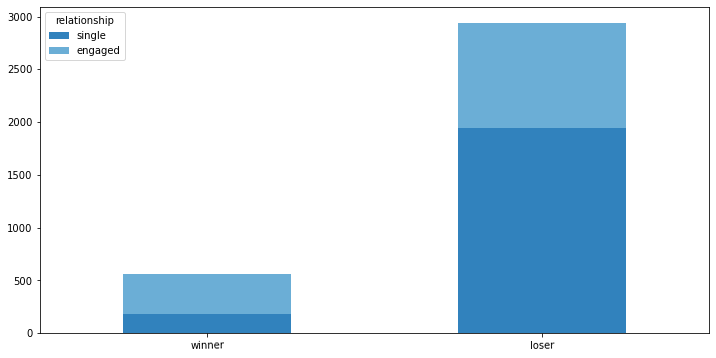

In [62]:
from matplotlib.colors import ListedColormap
import seaborn as sns

plot_stats_overall = stats_overall.drop(columns = 'win_ratio')
plot_stats_overall.index.set_names('relationship', inplace = True)

plot_stats_overall\
  .reindex(plot_stats_overall.sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True, rot=1,
          colormap=ListedColormap(sns.color_palette('tab20c', n_colors=2)), 
          figsize=(12,6));

In [63]:
win_ratio = stats_engageds.winner / (stats_engageds.loser + stats_engageds.winner)
stats_engageds["win_ratio"] = win_ratio
print("Statistics over players engaged in a friendship")
stats_engageds

Statistics over players engaged in a friendship


,winner,loser,win_ratio
betrayer,133.0,126.0,0.513514
betrayed,70.0,189.0,0.270270
neutral,171.0,1610.0,0.096013


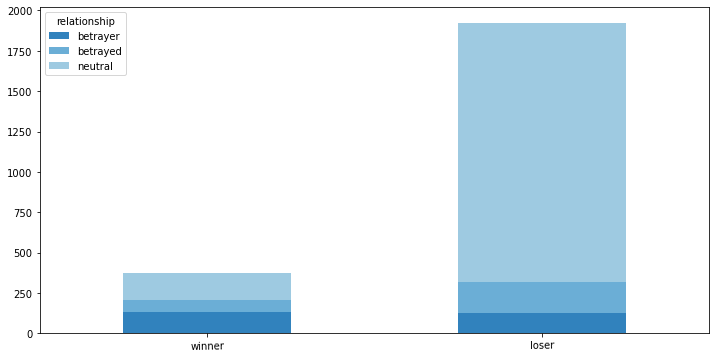

In [64]:
plot_stats_engageds = stats_engageds.drop(columns = 'win_ratio')
plot_stats_engageds.index.set_names('relationship', inplace = True)


plot_stats_engageds\
  .reindex(plot_stats_engageds.sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True, rot=1, 
          colormap=ListedColormap(sns.color_palette('tab20c', n_colors=3)),
          figsize=(12,6));

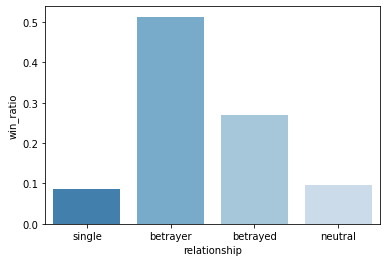

In [65]:
win_ratio_plot = pd.concat([stats_overall, stats_engageds])
win_ratio_plot.index.set_names('relationship', inplace = True)
win_ratio_plot

sns.barplot(data=win_ratio_plot.drop(index='engaged').reset_index(), 
            x='relationship', y='win_ratio',
           palette="tab20c");


What can we see here ? 
- among all players that were involved in a broken friendship (either *betrayer* or *betrayed*) the chances of winning go towards the betrayer. Betrayed players have much higher chances of loosing and about 5 times less chances of winning. . .. 
- the neutral players represents the majority of players, however their chances of winning are not much bigger than the chances of win than betrayed people. 

These results make us strongly believe that **betrayals strongly influence the outcome of the game**. 

What can we do next ? 

- select 250 games with  and without betrayals (and all with friendships), then do a matching based on the games properties, and look at what differs once a betrayal happened for the players who were engaged in a friendship !

- quantify agressivity of players towards others, and using the same dataset as before, try to see what happens to a player that was betrayed

## Difference between N1 and N2 for betrayals and for friendships counts



In [66]:
# 1. get the data
# games_id_N1 = np.load("data/subset_T500_N1/games_id.npy")
all_friendships_N1 = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)
# games_id_N2 = np.load("data/subset_T500_N2/games_id.npy")
all_friendships_N2 = np.load("data/subset_T500_N2/friendships.npy", allow_pickle=True)

In [67]:
def get_number_betrayals_friendships(friendship): 
    cols = [col for col in range(21) if np.count_nonzero(friendship[:, col] != 0)]
    n_friendships = len(cols)
    n_betrayals = np.count_nonzero([type(e) == str for col in friendship for e in col])
    return n_friendships, n_betrayals

N = 500
frame = pd.DataFrame(data = np.zeros(shape = (4*N, 3)), columns = ["N", "type", "number",])

for i in range(N):
    n_friendships_n1, n_betrayals_n1 = get_number_betrayals_friendships(all_friendships_N1[i])
    n_friendships_n2, n_betrayals_n2 = get_number_betrayals_friendships(all_friendships_N2[i])
    frame.loc[4*i, :] = ["1", "friendships", n_friendships_n1]
    frame.loc[4*i+1, :] = ["1", "betrayals", n_betrayals_n1]
    frame.loc[4*i+2, :] = ["2", "friendships", n_friendships_n2]
    frame.loc[4*i+3, :] = ["2",  "betrayals", n_betrayals_n2]
    
frame

,N,type,number
0,1,friendships,1.0
1,1,betrayals,1.0
2,2,friendships,1.0
3,2,betrayals,1.0
4,1,friendships,2.0
...,...,...,...
1995,2,betrayals,0.0
1996,1,friendships,2.0
1997,1,betrayals,1.0
1998,2,friendships,1.0


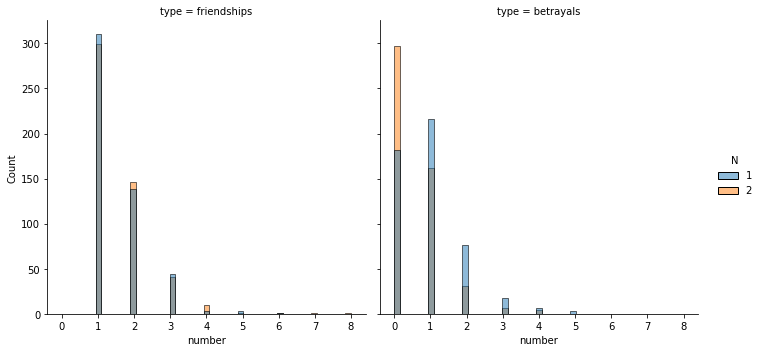

In [68]:
# make required the plot 
import seaborn as sns

sns.displot(data = frame, x = "number", hue = "N", kind = "hist", col = "type") ;

## Final score plot

For each game, we want to have the final score of 
- the betrayers
- the betrayed

In [69]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

scores = []

N = len(games_id)
for i in range(500):
    game_id = games_id[i]
    
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
    
    # get treatment 1 
    engageds = get_engageds(friendships)
    singles = get_singles(engageds)
    
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    neutrals = get_neutrals(betrayers, betrayeds)
    
    # compute statistics
    for player in betrayers: 
        scores.append(("betrayer", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
    for player in betrayeds: 
        scores.append(("victim", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
    for player in neutrals: 
        scores.append(("neutral", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
        
frame = pd.DataFrame(data = scores, columns = ["status", "final_score"])

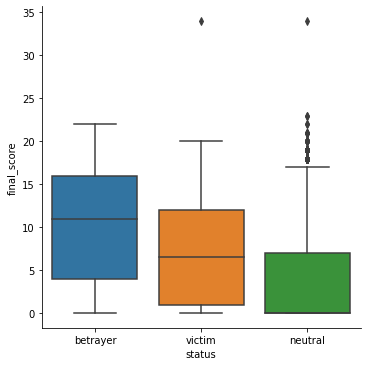

In [70]:
# make a plot using this 
sns.catplot(data = frame, y = "final_score", kind = "box", x = "status") # , col = "status")

## Games length distribution

In [72]:
import matplotlib.pyplot as plt

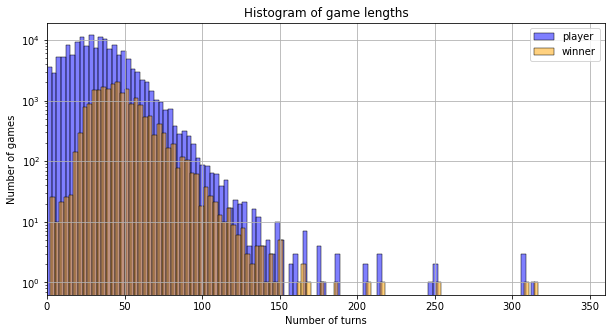

In [73]:
# HIstogram of game lengths for the average player and for the winner
plt.figure(figsize=(10,5))                             
winner_game_lengths =  all_players.sort_values('end_turn', ascending=False).drop_duplicates(['game_id'])
game_lengths = all_players.end_turn - all_players.start_turn

sns.histplot(game_lengths,
             alpha=0.5, 
             binwidth=3,
             color="blue")
sns.histplot(winner_game_lengths["end_turn"], 
             alpha=0.5, 
             binwidth=3, 
             color = "orange")


plt.title("Histogram of game lengths")
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.yscale("log")
plt.xlim(0,360 )
plt.grid(True)
plt.legend(["player","winner"])
plt.show()


In [74]:
# sample of 500 games picked randomly from the original dataset
games_features = np.load("data/subset_T500_N1_unfiltered/games_features_id.npy", allow_pickle=True)
unfiltered_games_features = pd.DataFrame({'FriendlyActs': games_features[:, 0], 'HostileActs': games_features[:, 1]})
unfiltered_games_features.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/subset500_N1_unfiltered/games_features_id.npy'

In [ ]:
g = sns.JointGrid(data=unfiltered_games_features, x="FriendlyActs", y="HostileActs", space=0, ratio=17);
g.plot_joint(sns.scatterplot, sizes=(30, 120),
             palette="tab20c", alpha=.6, legend=False);
g.plot_marginals(sns.rugplot, height=1, palette="tab20c", alpha=.6);


In [ ]:
games_features_melt = pd.melt(unfiltered_games_features, value_vars =['FriendlyActs', 'HostileActs'],
                             var_name='act_type', value_name='act_nb') 
games_features_melt.head()

In [ ]:
sns.boxplot(x="act_type", y="act_nb", palette="tab20c",
            data=games_features_melt);

## Serial betrayers

In [ ]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

N = len(games_id)
print("Analysis of serial betraying")
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
   
    # get treatment 2
    betrayers, _ = get_betrayers_and_betrayed(friendships)
    winners = get_winners(game_id)
    
    has_to_skip = False
    
    if len(betrayers) > 1:
        for b in betrayers:
            if has_to_skip:
                continue
            if np.count_nonzero([player == b for player in betrayers]) > 1: 
                print(game_id, "- serial betrayers", betrayers, "winners : ", winners)
                has_to_skip = True

# Games where a betrayer is betrayed

In [ ]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

N = len(games_id)
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
   
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    winners = get_winners(game_id)
    
    
    if len(betrayers) > 1:
        for b in betrayers:
            if np.count_nonzero([player == b for player in betrayeds]) > 1: 
                print(game_id, "-  betrayers", betrayers, " - victims: ", betrayeds , " - winners : ", winners)